# Financial Inclusion in Africa

Here we are going to describe and implement a solution to predicting whether an individual feature
set is likely to have a back account or not.

In [244]:
# for data processing
import pandas as pd
import seaborn as sns

# for display
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score

# for machine learning
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from skopt import forest_minimize

# for io
import warnings

warnings.filterwarnings('ignore')

##### Read files

In [245]:
# load files into a pandas dataframe

train = pd.read_csv('assets/Train.csv')
test = pd.read_csv('assets/Test.csv')

##### A Preview of the training data

In [246]:
train.head()

,country,year,uniqueid,bank_account,location_type,cellphone_access,household_size,age_of_respondent,gender_of_respondent,relationship_with_head,marital_status,education_level,job_type
0,Kenya,2018,uniqueid_1,Yes,Rural,Yes,3,24,Female,Spouse,Married/Living together,Secondary education,Self employed
1,Kenya,2018,uniqueid_2,No,Rural,No,5,70,Female,Head of Household,Widowed,No formal education,Government Dependent
2,Kenya,2018,uniqueid_3,Yes,Urban,Yes,5,26,Male,Other relative,Single/Never Married,Vocational/Specialised training,Self employed
3,Kenya,2018,uniqueid_4,No,Rural,Yes,5,34,Female,Head of Household,Married/Living together,Primary education,Formally employed Private
4,Kenya,2018,uniqueid_5,No,Urban,No,8,26,Male,Child,Single/Never Married,Primary education,Informally employed


## Combine train and test set for easy preprocessing

In [247]:
# mapping the bank account with 0 to NO and 1 to YES
train['bank_account'] = train['bank_account'].map({'No':0, 'Yes':1})

In [248]:
# Combine train and test set
ntrain = train.shape[0] # to be used to split train and test set from the combined dataframe

all_data = pd.concat((train, test)).reset_index(drop=True)
print(f'The shape of the combined dataframe is: {all_data.shape}')

The shape of the combined dataframe is: (33610, 13)


### Feature Engineering

In [249]:
cat_cols = ['country',	'location_type',	'cellphone_access',	'gender_of_respondent',	'relationship_with_head', 'marital_status', 'education_level',	'job_type']

# Encode categorical features
all_data = pd.get_dummies(data = all_data, columns = cat_cols)
all_data.head()

,year,uniqueid,bank_account,household_size,age_of_respondent,country_Kenya,country_Rwanda,country_Tanzania,country_Uganda,location_type_Rural,...,job_type_Dont Know/Refuse to answer,job_type_Farming and Fishing,job_type_Formally employed Government,job_type_Formally employed Private,job_type_Government Dependent,job_type_Informally employed,job_type_No Income,job_type_Other Income,job_type_Remittance Dependent,job_type_Self employed
0,2018,uniqueid_1,1.0,3,24,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
1,2018,uniqueid_2,0.0,5,70,1,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0
2,2018,uniqueid_3,1.0,5,26,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,2018,uniqueid_4,0.0,5,34,1,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0
4,2018,uniqueid_5,0.0,8,26,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [250]:
# Separate train and test data from the combined dataframe
train_df = all_data[:ntrain]
test_df = all_data[ntrain:]

We select the required columns that we will have in our input data set.
- We remove the uniqueid because it means nothing to the required output.
- We also remove the bank_account information because it has no organic output.
- We remove the year because time series information may cause the data fitting to overfit.

In [251]:
# Select main columns to be used in training
main_cols = all_data.columns.difference(['uniqueid', 'bank_account'])
x = train_df[main_cols]
y = train_df['bank_account']
# lets take a look now
x.head()

# Split data into train and test sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

### Model Training & Optimization

We now start modelling and training. We are going to the keras Sequential model to construct and
fit our input data set.

We will place the modelling process into its own function so that we can later optimize the hyper
params.

In [252]:
def modeller(params):
    model = XGBClassifier(learning_rate = params[0],
                            n_estimators = params[1],
                            max_depth = params[2],
                            min_child_weight = params[3],
                            gamma = params[4],
                            subsample = params[5],
                            colsample_bytree = params[6], seed = 42)
    auc = cross_val_score(model, x_train, y_train, cv = 10, scoring = 'roc_auc')
    print(auc.mean())
    return -auc.mean()

# then we define a tuning space for our random forest algo to optimize in
space = [(1e-3, 1e-1, 'log-uniform'), # learning rate
          (100, 2400), # n_estimators
          (1, 10), # max_depth
          (1, 6.), # min_child_weight
          (0, 0.5), # gamma
          (0.1, 1.), # subsample
          (0.1, 1.)] # colsample_bytree
# then we optimize
result = [0.02274869455295219, 768, 4, 4.008777026560296, 0.30297998739050575, 0.9336707906620142, 0.6859693229517501] # forest_minimize(modeller, space, random_state = 42, n_random_starts = 20, n_calls  = 20, verbose = 1).x
# print(result)

### Making predictions of the test set and creating a submission file

Once an optimized hyperparameter configuration is found we then model it and fit our data.

In [253]:
model = XGBClassifier(learning_rate = result[0],
                        n_estimators = result[1],
                        max_depth = result[2],
                        min_child_weight = result[3],
                        gamma = result[4],
                        subsample = result[5],
                        colsample_bytree = result[6], seed = 42, verbosity=0)

eval_s = [(x, y), (x_test, y_test)]
model.fit(x_train, y_train, eval_set=eval_s)

y_pred = model.predict(x_test)

print(f'XGB model accuracy: {accuracy_score(y_pred, y_test)*100}%')
# Make prediction on the test set

test_df['bank_account'] = model.predict(test_df[main_cols])
test_df['bank_account'] = test_df['bank_account'].astype(int)
# Create a submission file
sub_file = test_df.copy()
# we need to then remap the country name properly
def country(df):
    if df['country_Kenya'] == 1:
        return 'Kenya'
    elif df['country_Rwanda'] == 1:
        return 'Rwanda'
    elif df['country_Uganda'] == 1:
        return 'Uganda'
    else: return 'Tanzania'

sub_file['unique_id'] = sub_file.apply(lambda k: f'{k["uniqueid"]} x {country(k)}', axis=1)
sub_file = sub_file.filter(['unique_id', 'bank_account'], axis=1)
# Check the distribution of your predictions
# sns.countplot(sub_file.predictions);

[0]	validation_0-logloss:0.67956	validation_1-logloss:0.67954
[1]	validation_0-logloss:0.66681	validation_1-logloss:0.66676
[2]	validation_0-logloss:0.65426	validation_1-logloss:0.65418
[3]	validation_0-logloss:0.64249	validation_1-logloss:0.64235
[4]	validation_0-logloss:0.63101	validation_1-logloss:0.63078
[5]	validation_0-logloss:0.62023	validation_1-logloss:0.61994
[6]	validation_0-logloss:0.60966	validation_1-logloss:0.60938
[7]	validation_0-logloss:0.59950	validation_1-logloss:0.59919
[8]	validation_0-logloss:0.58976	validation_1-logloss:0.58937
[9]	validation_0-logloss:0.58067	validation_1-logloss:0.58027
[10]	validation_0-logloss:0.57158	validation_1-logloss:0.57118
[11]	validation_0-logloss:0.56281	validation_1-logloss:0.56240
[12]	validation_0-logloss:0.55444	validation_1-logloss:0.55396
[13]	validation_0-logloss:0.54623	validation_1-logloss:0.54568
[14]	validation_0-logloss:0.53851	validation_1-logloss:0.53789
[15]	validation_0-logloss:0.53099	validation_1-logloss:0.53038
[1

In [254]:
# Create a csv file and upload to zindi
sub_file.to_csv('baseline.csv', index = False)
# files.download('baseline.csv')

### Monitoring Learning Rate

We plot learning rate to tune and optimize our learning algorithm

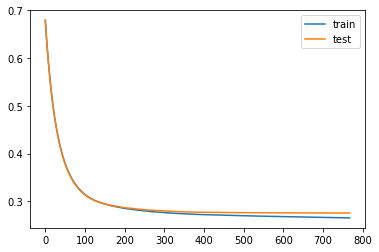

In [255]:
results = model.evals_result()
# files.download('Baseline.csv')
plt.plot(results['validation_0']['logloss'], label='train')
plt.plot(results['validation_1']['logloss'], label='test')
# show the legend
plt.legend()
# show the plot
plt.show()